
# Dataset GSM3215435

### load libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

### Import data

In [81]:
adata = sc.read_10x_mtx(
    'data/',  
    var_names='gene_symbols',
    cache=True)          

### Filtering same as used in Kostya's HW

In [82]:
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=20)

### Annotation by mitochondrial genes presented

In [83]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['mt'].value_counts()
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

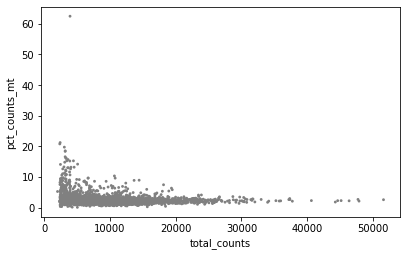

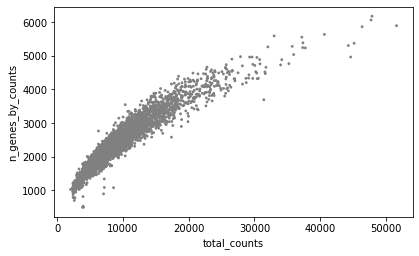

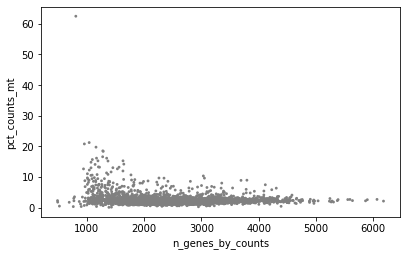

In [84]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

In this plots we see that there're several cells with mt content higher than 5% (filter that was used in paper), that's why we want to get rid of such cells and also cells with nfeature less than 1000


In [85]:
adata = adata[adata.obs.n_genes_by_counts > 1000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

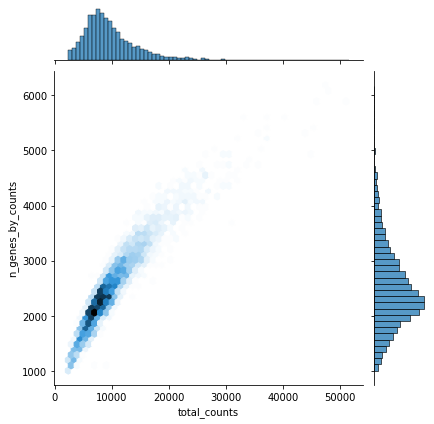

In [86]:
sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

### Normalization

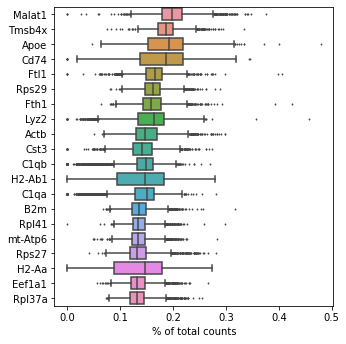

In [87]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])
sc.pp.normalize_total(adata, target_sum=1e4) # Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.log1p(adata) # log-normalization
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])
sc.pl.highest_expr_genes(adata, n_top=20, )

### Find Variable genes

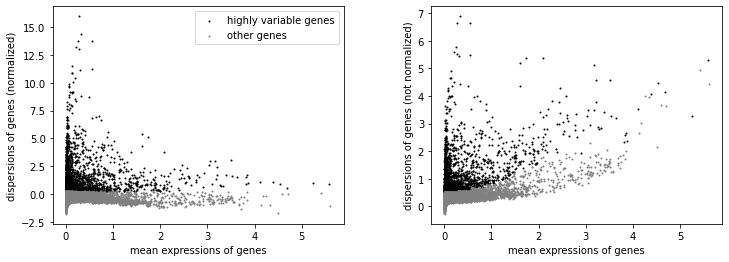

In [88]:
sc.pp.highly_variable_genes(adata,n_top_genes= 2000, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False)

In [89]:
adata.var['highly_variable'].value_counts()

False    10145
True      2000
Name: highly_variable, dtype: int64

<img src="genes.jpg" width="800" height="400">

We can see the nearly the same picture of variable genes found as it was in seurat

### PCA

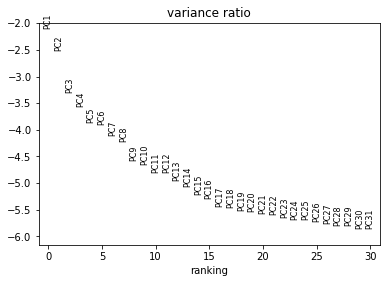

In [90]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

### Neighbourhood graph and UMAP

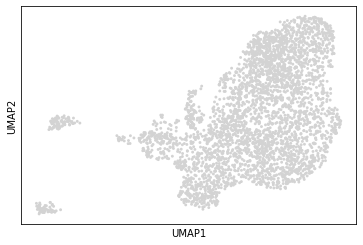

In [91]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

### Clusters


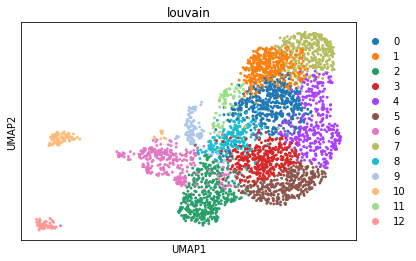

In [92]:
sc.tl.louvain(adata, resolution=1.2)
sc.pl.umap(adata, color='louvain')

In original paper tSNE instaed of UMAP was used, but here we can try to look if we will get the same clustering results in UMAP plot. We already got 13 clusters, which is more than was reported by the authors.

## Look at known markers

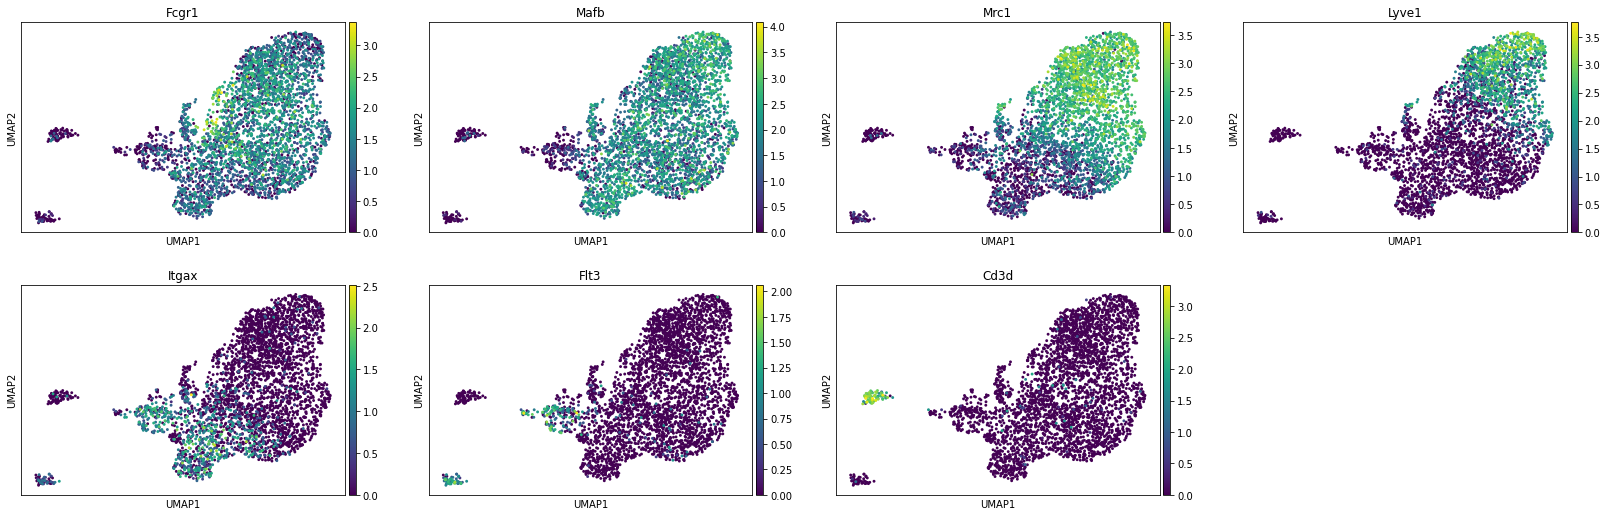

In [93]:
sc.pl.umap(adata, color=["Fcgr1","Mafb","Mrc1","Lyve1", "Itgax", "Flt3", 'Cd3d'])

Even though clusters and plot doesn't look the same as in the article, markers still show the same information about clusters. For example expression of Fcgr1 shows us that the biggest part of the plot corresponds to Macrophages, as in the article.


<img src="mp.jpg" width="400" height="200">

While some more specific markers shows that some smaller clusters correspond to populations of macrophages (adventitial - Mrc1), dendritic cells - Flt3 or T-cells - CD3d.

Let's try to make a dictionary with known markers and build some other plots with annotation

In [94]:
marker_genes_dict = {
    'MP': ['Fcgr1', 'Mafb'],
    'Adv MP': ['Mrc1', 'Lyve1'],
    'IFN resp MP': ['Oasl1', 'Stat1'],
    'Proliferating MP': ['Ccna2', 'Cdk1'],
    'T-cells': ['Cd3d'],
    'DC': ['Flt3', 'Zbtb46', 'Itgae'],
}


categories: 0, 1, 2, etc.
var_group_labels: MP, Adv MP, IFN resp MP, etc.


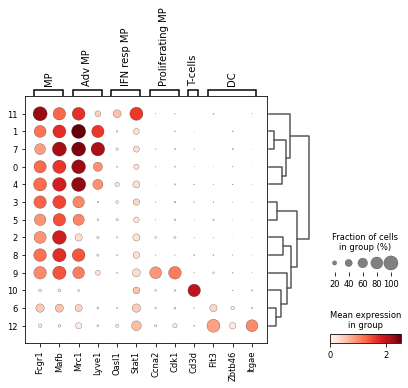

In [95]:
sc.pl.dotplot(adata, marker_genes_dict, 'louvain', dendrogram=True)

THis plot helps us to see that macrophages population include clusters with four groups of cells: IFN responsive MP, Proliferating, Adventitial and general macrophages. Other clusters correspond to DCs and T-cells. Now we can annotate clusters by cell type.

categories: Adv Macrophages, DC, IFN resp Macrophages, etc.
var_group_labels: MP, Adv MP, IFN resp MP, etc.


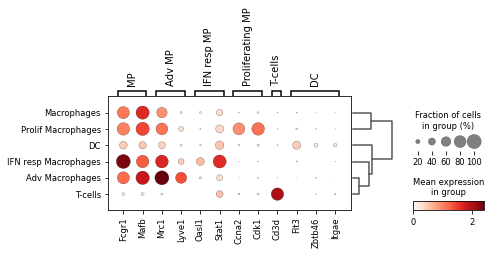

In [101]:
cluster2annotation = {
     '0': 'Adv Macrophages',
     '1': 'Adv Macrophages',
     '4': 'Adv Macrophages',
     '7': 'Adv Macrophages',
     '2': 'Macrophages',
     '3': 'Macrophages',
     '5': 'Macrophages',
     '11': 'IFN resp Macrophages',
     '6': 'DC',
     '10': 'T-cells',
     '9': 'Prolif Macrophages',
     '12': 'DC',
     '8': 'Macrophages'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell type'] = adata.obs['louvain'].map(cluster2annotation).astype('category')
sc.pl.dotplot(adata, marker_genes_dict, 'cell type', dendrogram=True)



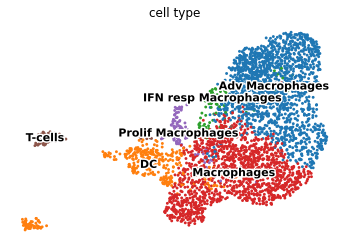

In [102]:
sc.pl.umap(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=11, legend_fontoutline=3)

categories: 0, 1, 2, etc.
var_group_labels: MP, Adv MP, IFN resp MP, etc.


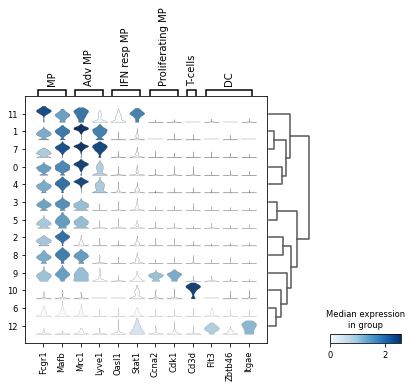

In [103]:
sc.pl.stacked_violin(adata, marker_genes_dict, groupby='louvain', swap_axes=False, dendrogram=True)

### The other thing we can do is to run DE to find the markers of all the clusters:

In [104]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Hspa1a,Pf4,Lgals3,Ccl4,Ccl8,Ifrd1,Napsa,Folr2,Ccr2,Stmn1,Tmsb10,Bst2,Cst3


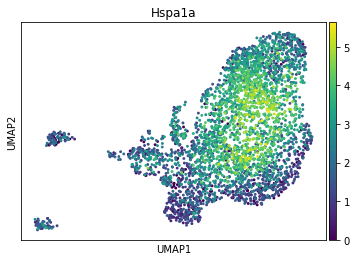

In [105]:
sc.pl.umap(adata, color=["Hspa1a"])

<img src="markers.jpg" width="800" height="400">


Comparing to markers from Seurat hw we can see that there are some differences between clusters, but we can explain them as differences in the positioning of clusters in the plot and their number ids, but not their biological differences. Detailed look cana help us to understand that most of the markers identified by scanpy can be found in the table from seurat.
